In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional, Embedding, Input, TimeDistributed
from model.load_data import train_test_split, train_test_split_LSTM

from model.scoring_metrics import get_windiff, get_pk, get_k_kappa

from model_trainer_and_tester import read_in_dataset_lstm, test_set_evaluate_multiple_lstm
from tensorflow import keras

batch_size = 64

# I optimize on this, I think?
LSTM_units = 20

features = ['pause','speakerChange', 'similarity', 'f0_diff', 'f0_baseline_diff']

In [2]:
!pip install tensorflow-addons
!pip install typeguard

In [4]:
#load the data
shifts = [-2, -1, 0, 1, 2]

n_timesteps = len(shifts)
feature_count = len(features)

X_train, Y_train = read_in_dataset_lstm(features, shifts, to_read='train')
X_test, Y_test = read_in_dataset_lstm(features, shifts, to_read='test')
#train_test_split_LSTM(datasets, results_merged_path, n_timesteps, split=train_ratio)

print(X_train.shape)
print(Y_train.shape)

# So, the model should be tanh activations and sigmoid outpiut layers...
# I'm going to guess both layers should be blstm... but that's it pretty much I think?

(47450, 5, 5)
(47450, 5, 1)


In [17]:
# I'm going to do sample weight here. For now I'll just set the weight to be... half of the number of weird samples?

sample_weight = np.ones(shape=(len(Y_train),))
# I'm gonna increase the weight by the inverse of the proportion of weird examples that there are
# How I define if there is a weird sample is by summing along the 2D squares to find where there's a 1, and then does a sum of times there's a 1
# I'm going to do n_timesteps times the inverse count frequency, because in the final version we only predict with the center value. So to correct for this I add this increase
new_weight = 5*n_timesteps*len(Y_train)/np.sum(Y_train, axis=1).sum()

# Have to do a flatten() inside because of weird numpy stuff with a length 1 dimension
sample_weight[(np.sum(Y_train, axis=1) >= 1).flatten()] = new_weight

sample_weight

array([1., 1., 1., ..., 1., 1., 1.])

In [6]:
# for num_layers in range(1, 5):
#     # It's 31 per step, because it allows for there to be 16 trials, and for me to not go crazy
#     for hidden_units in range(16, 513, 31):
#         #print("Starting model: " + str((num_layers, hidden_units)))
#         model = Sequential()
#         # For the input number of units, I'll assume that number of timesteps * features is a good enough value
#         for _ in range(num_layers):
#             model.add(Bidirectional(LSTM(hidden_units, activation='tanh', return_sequences=True, dropout=0.3), input_shape=(n_timesteps, feature_count)))
#         model.add(Bidirectional(LSTM(hidden_units, activation='sigmoid', return_sequences=True, dropout=0.3)))
#         # This last time distributed is super important, it follows the output structure of the paper I've been following closely
#         model.add(TimeDistributed(Dense(1, activation='sigmoid')))
#         model.compile(loss='binary_crossentropy', optimizer='RMSprop',
#                       metrics=[keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')],
#                       weighted_metrics=[])
#
#         # train the model
#         history = model.fit(X_train, Y_train,
#                   batch_size=batch_size,
#                   epochs=20,
#                   #class_weight= {0:1, 1:10},
#                   # sample_weight_mode='temporal',
#                   sample_weight=sample_weight,
#                   validation_split=0.1,
#                   verbose=0
#                   )
#
#         print("Finished model: " + str((num_layers, hidden_units)) + " with Precision: " + str(history.history['val_precision'][-1]))
#
#         hist_results_dict[(num_layers, hidden_units)] = history
#         # It's -1, to take the last accuracy measure obtained
#         acc_results_dict[(num_layers, hidden_units)] = (history.history['val_precision'][-1], history.history['val_recall'][-1])

<AxesSubplot: xlabel='Unnamed: 0', ylabel='Unnamed: 1'>

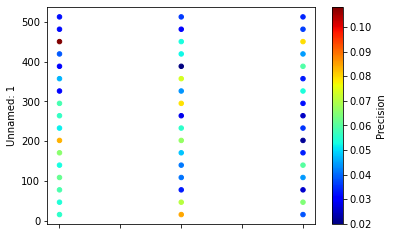

In [7]:
results = pd.read_csv('results_blstm.csv')

results.plot.scatter('Unnamed: 0', 'Unnamed: 1', c='Precision', colormap='jet')

<AxesSubplot: xlabel='Unnamed: 0', ylabel='Unnamed: 1'>

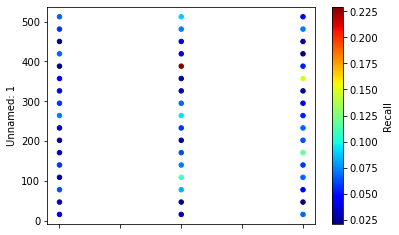

In [8]:
results.plot.scatter('Unnamed: 0', 'Unnamed: 1', c='Recall', colormap='jet')

In the first plot, brighter color means better precision, in the second it means better precision.

I could've done the testing better.... I feel focusing on too much hidden layers is not the best.

The middle one for 2, that has around 300 points seems to be a pretty good middle point for the values. This is definitely more art than science, but the results obtained don't give a reliable heat map. This is also because that recall was also good enough.

I definitely also made a mistake with the evaluation, but that's okay.

So, 2 hidden layers and 200 units.

In [23]:
def balanced_cross_entropy(beta):
    def loss(y_true, y_pred):
        weight_a = beta * tf.cast(y_true, tf.float32)
        weight_b = (1 - beta) * tf.cast(1 - y_true, tf.float32)

        o = (tf.math.log1p(tf.exp(-tf.abs(y_pred))) + tf.nn.relu(-y_pred)) * (weight_a + weight_b) + y_pred * weight_b
        return tf.reduce_mean(o)

    return loss

In [30]:
hidden_units = 200

model = Sequential()
# For the input number of units, I'll assume that number of timesteps * features is a good enough value
model.add(Bidirectional(LSTM(hidden_units, activation='tanh', return_sequences=True, dropout=0.3), input_shape=(n_timesteps, feature_count)))
model.add(Bidirectional(LSTM(hidden_units, activation='tanh', return_sequences=True, dropout=0.3), input_shape=(n_timesteps, feature_count)))

model.add(Bidirectional(LSTM(hidden_units, activation='sigmoid', return_sequences=True, dropout=0.3)))
# This last time distributed is super important, it follows the output structure of the paper I've been following closely
model.add(TimeDistributed(Dense(1, activation='sigmoid')))

import tensorflow_addons as tfa
model.compile(loss=tfa.losses.sigmoid_focal_crossentropy, optimizer='RMSprop',
              metrics=[keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')],
              weighted_metrics=[]
              )

# train the model
history = model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=10,
          #class_weight= {0:1, 1:10},
          # sample_weight_mode='temporal',
          sample_weight=sample_weight,
          validation_split=0.1,
          )

Epoch 1/10
668/668 [==============================] - 128s 174ms/step - loss: 1.2342 - precision: 0.1195 - recall: 0.0188 - val_loss: 0.9840 - val_precision: 0.1667 - val_recall: 0.0208
Epoch 2/10
668/668 [==============================] - 113s 169ms/step - loss: 1.1835 - precision: 0.1466 - recall: 0.0387 - val_loss: 1.0027 - val_precision: 0.0714 - val_recall: 0.0052
Epoch 3/10
668/668 [==============================] - 109s 163ms/step - loss: 1.1679 - precision: 0.1253 - recall: 0.0278 - val_loss: 0.9601 - val_precision: 0.0909 - val_recall: 0.0052
Epoch 4/10
668/668 [==============================] - 118s 177ms/step - loss: 1.1609 - precision: 0.1308 - recall: 0.0238 - val_loss: 1.0180 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
668/668 [==============================] - 122s 182ms/step - loss: 1.1552 - precision: 0.1715 - recall: 0.0233 - val_loss: 0.9839 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/10
668/668 [==============================] - 

In [31]:
#model.save('blstm_optimized_model')
temp_results = test_set_evaluate_multiple_lstm(model, features, shifts)

86/86 [==============================] - 2s 20ms/step


In [32]:
temp_results.mean()

Pk         0.400382
K-k        0.015582
Windiff    0.402287
dtype: float64

In [14]:
results = test_set_evaluate_multiple_lstm(model, features, shifts)

86/86 [==============================] - 1s 12ms/step


In [15]:
results.mean()

Pk         0.592640
K-k       -0.002417
Windiff    0.946877
dtype: float64

Still kinda bad... actually that's really bad. But hey, nothing to do!

So... I tested out a different model... and got scarily good results? Like again... wtf

This is also a... not tuned model. Like... at alllll

In [6]:
temp_features = ['pause', 'speakerChange', 'similarity', 'f0_diff', 'f0_baseline_diff']

# These are parameters that are constant regardless of the model
batch_size = 64
shifts = [-2, -1, 0, 1, 2]
hidden_units = 200

n_timesteps = len(shifts)
feature_count = len(temp_features)

X_train, Y_train = read_in_dataset_lstm(temp_features, shifts, to_read='train')

sample_weight = np.ones(shape=(len(Y_train),))
# I'm gonna increase the weight by the inverse of the proportion of weird examples that there are
# How I define if there is a weird sample is by summing along the 2D squares to find where there's a 1, and then does a sum of times there's a 1
# I'm going to do n_timesteps times the inverse count frequency, because in the final version we only predict with the center value. So to correct for this I add this increase
new_weight = n_timesteps*len(Y_train)/np.sum(Y_train, axis=1).sum()

# Have to do a flatten() inside because of weird numpy stuff with a length 1 dimension
sample_weight[(np.sum(Y_train, axis=1) >= 1).flatten()] = new_weight

model = Sequential()
# For the input number of units, I'll assume that number of timesteps * features is a good enough value
model.add(Bidirectional(LSTM(hidden_units, activation='tanh', return_sequences=True, dropout=0.3), input_shape=(n_timesteps, feature_count)))
model.add(Bidirectional(LSTM(hidden_units, activation='tanh', return_sequences=True, dropout=0.3), input_shape=(n_timesteps, feature_count)))

model.add(Bidirectional(LSTM(hidden_units, activation='sigmoid', return_sequences=True, dropout=0.3)))
# This last time distributed is super important, it follows the output structure of the paper I've been following closely
model.add(TimeDistributed(Dense(1, activation='sigmoid')))

import tensorflow_addons as tfa
model.compile(loss='binary_crossentropy', optimizer='RMSprop',
              metrics=[keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')],
              weighted_metrics=[]
              )

# train the model
print('Fitting model')
history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=1,
                    #class_weight= {0:1, 1:10},
                    # sample_weight_mode='temporal',
                    sample_weight=sample_weight,
                    validation_split=0.1,
                    verbose=1
                    )

temp_results = test_set_evaluate_multiple_lstm(model, temp_features, shifts)

Fitting model
86/86 [==============================] - 1s 10ms/step


In [8]:
temp_results.mean()

Pk         0.033247
K-k        0.932966
Windiff    0.039905
dtype: float64